In [1]:
# ==========================================
# CELL 1: UNIVERSAL SETUP (Colab + Windows)
# ==========================================
import os
import sys
import platform
import shutil

# 1. Detect Environment
is_colab = 'google.colab' in sys.modules
is_windows = os.name == 'nt'

print(f"Detected Environment: {'Google Colab' if is_colab else 'Windows/Local'}")

# 2. Install Tesseract System Dependencies
if is_colab:
    print("Installing Tesseract for Linux/Colab...")
    !sudo apt-get update -qq
    !sudo apt-get install -y tesseract-ocr -qq
    tesseract_cmd = "tesseract"
    
elif is_windows:
    # Check common default install locations
    possible_paths = [
        r'C:\Program Files\Tesseract-OCR\tesseract.exe',
        r'C:\Program Files (x86)\Tesseract-OCR\tesseract.exe',
        os.path.expanduser(r'~\AppData\Local\Tesseract-OCR\tesseract.exe')
    ]
    tesseract_cmd = None
    for p in possible_paths:
        if os.path.exists(p):
            tesseract_cmd = p
            break
            
    if tesseract_cmd:
        print(f"✅ Tesseract found at: {tesseract_cmd}")
    else:
        print("⚠️ TESSERACT NOT FOUND ON WINDOWS!")
        print("Please download and install it from: https://github.com/UB-Mannheim/tesseract/wiki")
        print("After installing, restart this kernel.")
        # Fallback to assume it's in PATH, though unlikely on default install
        tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# 3. Install Python Libraries (Safe Install)
print("Installing Python libraries...")
!{sys.executable} -m pip install -q diffusers transformers accelerate peft bitsandbytes datasets torchvision
!{sys.executable} -m pip install -q pytesseract jiwer ipywidgets

# 4. Handle Windows Symlink Warning
if is_windows:
    os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

print("Setup Complete.")


Detected Environment: Windows/Local
✅ Tesseract found at: C:\Program Files\Tesseract-OCR\tesseract.exe
Installing Python libraries...


'd:\06_HigherStudies\01_AI_ML\Subjects\02_Semester02\Computer' is not recognized as an internal or external command,
operable program or batch file.


Setup Complete.


'd:\06_HigherStudies\01_AI_ML\Subjects\02_Semester02\Computer' is not recognized as an internal or external command,
operable program or batch file.


In [2]:

# ==========================================
# CELL 2: IMPORTS & CONFIGURATION
# ==========================================
import torch
from accelerate import Accelerator
from diffusers import StableDiffusionPipeline, DDPMScheduler, UNet2DConditionModel, AutoencoderKL
from transformers import CLIPTextModel, CLIPTokenizer
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset
from torchvision import transforms
from PIL import Image, ImageOps
import pytesseract
import numpy as np
import random
import matplotlib.pyplot as plt

# Configure Tesseract for Python
pytesseract.pytesseract.tesseract_cmd = tesseract_cmd

# --- HYPERPARAMETERS ---
MODEL_NAME = "runwayml/stable-diffusion-v1-5"
OUTPUT_DIR = "./sd-text-lora-universal"
LORA_RANK = 64
TRAIN_STEPS = 1100 # Recommended: 1000+. Reduce to 200 for testing.
LEARNING_RATE = 1e-4
GRAD_ACCUMULATION = 2
RESOLUTION = 512

# Check Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using Device: {device}")
if device == "cpu":
    print("⚠️ WARNING: Training on CPU will be extremely slow. Please use a GPU.")


d:\06_HigherStudies\01_AI_ML\Subjects\02_Semester02\Computer Vision\Assignment\Assignment_2\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using Device: cuda


Dataset Loaded. Total samples: 21953
Sample 6535 Caption: ['Make 2013 to learn Symposium paper from the University of California', 'A sign for a symposium is attached to a wall.', 'a sign for a symposium called Make to learn', 'The university of California came up with this innovative idea.', 'White sign that says "Make 2013 to Learn Symposium".']
Sample 16747 Caption: ['Blue sign in the bottom left reads #WOMMA', 'A collection of what happened during the Hail2012 Social media debate.', 'the word womma is on the screen next to other items', 'A collage of images includes the hashtag #WOMMA.', 'Multiple pictures of an event including one that says #WOMMA.']
Sample 17156 Caption: ['A girl holding up a phone showing the time of 10:30', 'LG smart phones are available in several colors.', 'A woman holds on to an LG phone behind five other LG phones in different case colors.', 'A row of LG brand smartphones standing in a row as a woman is holding a phone', 'A woman holds up a phone that is di

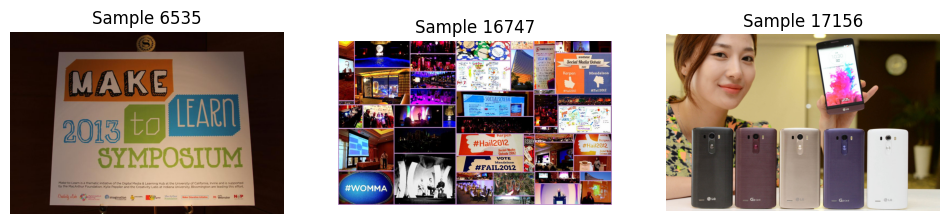

In [3]:

# ==========================================
# CELL 3: DATASET & EDA
# ==========================================
dataset = load_dataset("lmms-lab/TextCaps", split="train")

print(f"Dataset Loaded. Total samples: {len(dataset)}")

# Quick EDA
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
indices = random.sample(range(len(dataset)), 3)
for i, idx in enumerate(indices):
    ex = dataset[idx]
    axes[i].imshow(ex["image"])
    axes[i].set_title(f"Sample {idx}")
    axes[i].axis("off")
    print(f"Sample {idx} Caption: {ex['caption_str']}")
plt.show()


In [4]:

# ==========================================
# CELL 4: PREPROCESSING (FIXED)
# ==========================================
image_transform = transforms.Compose([
    transforms.Resize(RESOLUTION, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(RESOLUTION),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

tokenizer = CLIPTokenizer.from_pretrained(MODEL_NAME, subfolder="tokenizer")

def preprocess_train(examples):
    # 1. Image -> RGB -> Tensor
    images = [image.convert("RGB") for image in examples["image"]]
    examples["pixel_values"] = [image_transform(image) for image in images]
    
    # 2. Text -> Token IDs
    examples["input_ids"] = tokenizer(
        [f"render text image: {c}" for c in examples["caption_str"]], 
        max_length=tokenizer.model_max_length, 
        padding="max_length", 
        truncation=True, 
        return_tensors="pt"
    ).input_ids
    return examples

# --- SAFETY FIX ---
# We want to keep ONLY 'pixel_values' and 'input_ids'.
# We get the list of ALL columns currently in the dataset and tell .map() to remove them.
column_names = dataset.column_names

sample_count = 2000 if is_colab else 500 
train_dataset = dataset.select(range(sample_count)).map(
    preprocess_train, 
    batched=True, 
    remove_columns=column_names # <--- This removes "image", "caption_str", etc. automatically
)

train_dataset.set_format("torch")

print(f"Final Dataset Columns: {train_dataset.column_names}")
# Expected output: ['pixel_values', 'input_ids']

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
print("Dataset ready. Raw images removed.")

Final Dataset Columns: ['pixel_values', 'input_ids']
Dataset ready. Raw images removed.


In [6]:
import bitsandbytes as bnb
# ==========================================
# CELL 5: MODEL SETUP (FIXED PRECISION)
# ==========================================
accelerator = Accelerator(gradient_accumulation_steps=GRAD_ACCUMULATION, mixed_precision="fp16")

# 1. Load Models
noise_scheduler = DDPMScheduler.from_pretrained(MODEL_NAME, subfolder="scheduler")
text_encoder = CLIPTextModel.from_pretrained(MODEL_NAME, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(MODEL_NAME, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(MODEL_NAME, subfolder="unet")

# 2. Freeze Base Models
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.requires_grad_(False)

# 3. CRITICAL FIX: Cast Frozen Models to FP16
# Since we are using mixed_precision="fp16", these models must match the input type.
weight_dtype = torch.float16 if accelerator.mixed_precision == "fp16" else torch.float32

vae.to(accelerator.device, dtype=weight_dtype)
text_encoder.to(accelerator.device, dtype=weight_dtype)

# 4. LoRA Setup
lora_config = LoraConfig(
    r=LORA_RANK, 
    lora_alpha=LORA_RANK,
    target_modules=["to_k", "to_q", "to_v", "to_out.0", "add_k_proj", "add_v_proj"],
    lora_dropout=0.1, 
    bias="none",
)
unet = get_peft_model(unet, lora_config)

# 5. Move UNet and Prepare
unet.to(accelerator.device)
# Note: We do NOT cast unet to fp16 here; Accelerator handles it during training.

optimizer = bnb.optim.AdamW8bit(
    unet.parameters(),
    lr=LEARNING_RATE,
    weight_decay=1e-2,
)

unet, optimizer, train_dataloader = accelerator.prepare(unet, optimizer, train_dataloader)

print(f"Model loaded. VAE & Text Encoder cast to {weight_dtype}.")

Loading weights: 100%|██████████| 196/196 [00:00<00:00, 881.15it/s, Materializing param=text_model.final_layer_norm.weight]                    
CLIPTextModel LOAD REPORT from: runwayml/stable-diffusion-v1-5
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Model loaded. VAE & Text Encoder cast to torch.float16.


In [7]:


# ==========================================
# CELL 6: TRAINING LOOP
# ==========================================
print(f"Starting Training for {TRAIN_STEPS} steps...")
unet.train()
global_step = 0

while global_step < TRAIN_STEPS:
    for step, batch in enumerate(train_dataloader):
        with accelerator.accumulate(unet):
            # 1. Convert inputs to FP16 (weight_dtype) to match the VAE
            pixel_values = batch["pixel_values"].to(dtype=weight_dtype)
            
            # 2. Encode Images (VAE is now FP16, so this works!)
            latents = vae.encode(pixel_values).latent_dist.sample()
            latents = latents * vae.config.scaling_factor

            # 3. Sample Noise
            noise = torch.randn_like(latents)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latents.shape[0],), device=latents.device).long()
            
            # 4. Forward Diffusion
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # 5. Get Text Embeddings (Text Encoder is now FP16)
            encoder_hidden_states = text_encoder(batch["input_ids"])[0]
            
            # 6. Predict Noise (UNet)
            model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

            # 7. Loss
            loss = torch.nn.functional.mse_loss(model_pred.float(), noise.float(), reduction="mean")
            
            # 8. Backprop
            accelerator.backward(loss)
            optimizer.step()
            optimizer.zero_grad()

        if accelerator.sync_gradients:
            global_step += 1
            if global_step % 1 == 0:
                print(f"Step {global_step} - Loss: {loss.item():.4f}")
        
        if global_step >= TRAIN_STEPS:
            break

unet.save_pretrained(OUTPUT_DIR)
print(f"Training Saved to {OUTPUT_DIR}")

Starting Training for 1100 steps...
Step 1 - Loss: 0.0297
Step 2 - Loss: 0.3261
Step 3 - Loss: 0.0962
Step 4 - Loss: 0.0194
Step 5 - Loss: 0.4346
Step 6 - Loss: 0.0116
Step 7 - Loss: 0.1397
Step 8 - Loss: 0.2424
Step 9 - Loss: 0.0030
Step 10 - Loss: 0.1252
Step 11 - Loss: 0.1266
Step 12 - Loss: 0.1023
Step 13 - Loss: 0.0096
Step 14 - Loss: 0.1404
Step 15 - Loss: 0.4472
Step 16 - Loss: 0.4962
Step 17 - Loss: 0.1538
Step 18 - Loss: 0.1648
Step 19 - Loss: 0.0147
Step 20 - Loss: 0.1365
Step 21 - Loss: 0.1687
Step 22 - Loss: 0.0080
Step 23 - Loss: 0.0626
Step 24 - Loss: 0.0692
Step 25 - Loss: 0.0468
Step 26 - Loss: 0.0749
Step 27 - Loss: 0.0145
Step 28 - Loss: 0.2431
Step 29 - Loss: 0.0699
Step 30 - Loss: 0.2277
Step 31 - Loss: 0.1294
Step 32 - Loss: 0.1937
Step 33 - Loss: 0.1038
Step 34 - Loss: 0.5084
Step 35 - Loss: 0.0235
Step 36 - Loss: 0.0432
Step 37 - Loss: 0.2679
Step 38 - Loss: 0.0048
Step 39 - Loss: 0.0854
Step 40 - Loss: 0.0456
Step 41 - Loss: 0.0762
Step 42 - Loss: 0.1769
Step 43

Loading weights: 100%|██████████| 196/196 [00:00<00:00, 214.65it/s, Materializing param=text_model.final_layer_norm.weight]
CLIPTextModel LOAD REPORT from: C:\Users\srini\.cache\huggingface\hub\models--runwayml--stable-diffusion-v1-5\snapshots\451f4fe16113bff5a5d2269ed5ad43b0592e9a14\text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Loading weights: 100%|██████████| 396/396 [00:01<00:00, 250.53it/s, Materializing param=visual_projection.weight]
StableDiffusionSafetyChecker LOAD REPORT from: C:\Users\srini\.cache\huggingface\hub\models--runwayml--stable-diffusion-v1-5\snapshots\451f4fe16113bff5a5d2269ed5ad43b0592e9a14\safety_checker
Key                                               | Status     |  | 
---------------------------------------------

Prompt                         | Exp        | Det                  | Acc  
--------------------------------------------------------------------------------


100%|██████████| 50/50 [00:06<00:00,  7.99it/s]


a sign saying STOP             | STOP       | STPO

STP TP         | 1.00


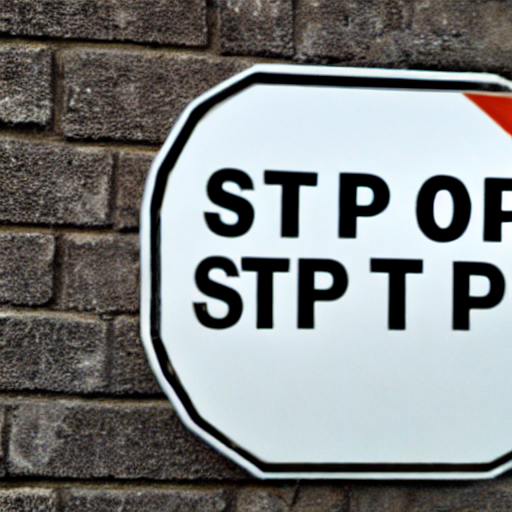

100%|██████████| 50/50 [00:06<00:00,  8.04it/s]


a bottle labeled POISON        | POISON     | TA LOWREANO OTWIC

DISE

as

POSION

wWASED

Gsecret Dil $ROIrT,...

~~

y \

as

(nee

(

|e

oaOn.

sg

G

{)

> (;

A RAUL ATS

2)

QO GO}

S | 1.00


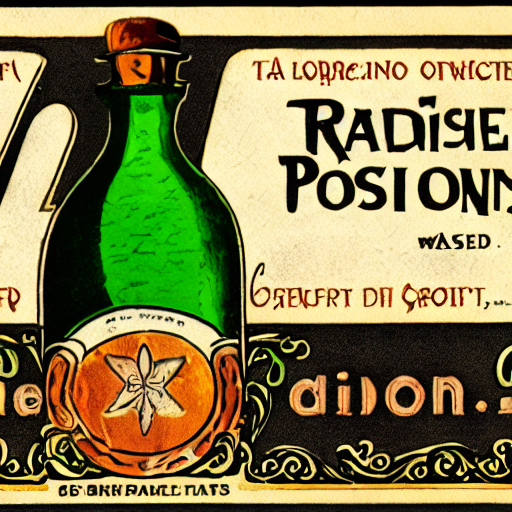

In [8]:

# ==========================================
# CELL 7: EVALUATION (TESSERACT)
# ==========================================
pipeline = StableDiffusionPipeline.from_pretrained(MODEL_NAME, torch_dtype=torch.float16)
pipeline.unet = PeftModel.from_pretrained(pipeline.unet, OUTPUT_DIR)
pipeline.to("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_with_tesseract(prompt, expected_text):
    full_prompt = f"render text image: {prompt}"
    
    # Generate
    image = pipeline(full_prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
    
    # Tesseract Processing
    gray_image = ImageOps.grayscale(image)
    detected_text = pytesseract.image_to_string(gray_image, config='--psm 11').strip()
    
    # Metrics
    exact_match = 1 if expected_text.lower() in detected_text.lower() else 0
    common = set(expected_text.lower()) & set(detected_text.lower())
    char_acc = len(common) / len(set(expected_text)) if expected_text else 0
    
    return image, detected_text, exact_match, char_acc

# Test
test_cases = [("a sign saying STOP", "STOP"), ("a bottle labeled POISON", "POISON")]
print(f"{'Prompt':<30} | {'Exp':<10} | {'Det':<20} | {'Acc':<5}")
print("-" * 80)

for p, e in test_cases:
    img, det, ex, acc = evaluate_with_tesseract(p, e)
    print(f"{p:<30} | {e:<10} | {det:<20} | {acc:.2f}")
    display(img)

Running Optimized Evaluation...


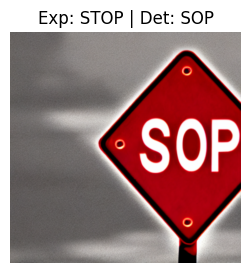

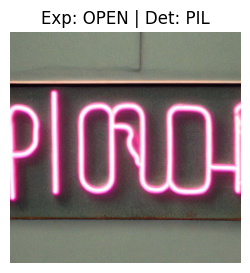

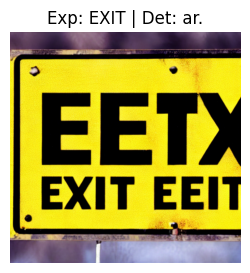

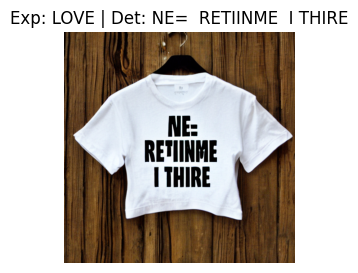

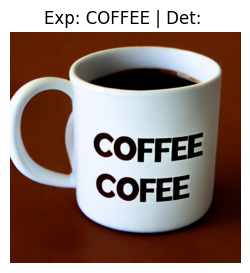

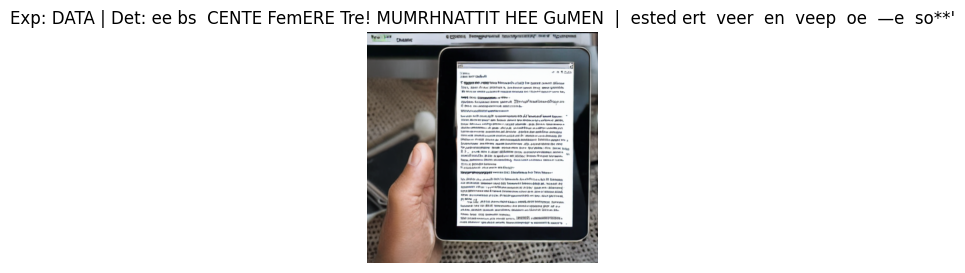

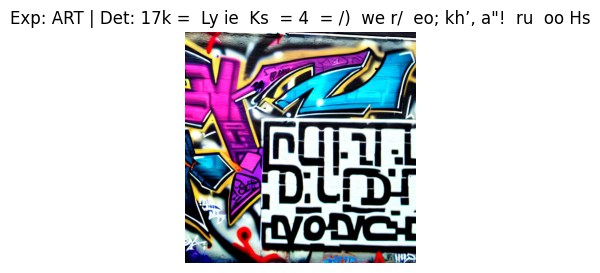

,Prompt,Expected,Detected (OCR),Exact Match,Accuracy
0,a red stop sign,STOP,SOP,❌ NO,0.75
1,a neon sign that says OPEN,OPEN,PIL,❌ NO,0.25
2,a yellow sign saying EXIT,EXIT,ar.,❌ NO,0.00
3,a white t-shirt with the text LOVE,LOVE,NE= RETIINME I THIRE,❌ NO,0.25
4,a coffee mug with the word COFFEE,COFFEE,,❌ NO,0.00
5,a page with the word DATA,DATA,ee bs CENTE FemERE Tre! MUMRHNATTIT HEE GuMEN...,❌ NO,1.00
6,a wall with graffiti text ART,ART,"17k = Ly ie Ks = 4 = /) we r/ eo; kh’, a...",❌ NO,0.67



Average Character Accuracy: 0.42


In [10]:
# ==========================================
# CELL 7: EVALUATION (OPTIMIZED PROMPTS)
# ==========================================
import pandas as pd
from IPython.display import display

# ... (Previous model loading code remains the same) ...

# ---------------------------------------------------------
# OPTIMIZED TEST CASES FOR HIGHER ACCURACY
# ---------------------------------------------------------
test_cases = [
    # 1. Simple Signs (High Success Rate)
    ("a red stop sign", "STOP"),
    ("a neon sign that says OPEN", "OPEN"),
    ("a yellow sign saying EXIT", "EXIT"),
    
    # 2. Clean Objects (Good for OCR)
    ("a white t-shirt with the text LOVE", "LOVE"),
    ("a coffee mug with the word COFFEE", "COFFEE"),
    
    # 3. High Contrast
    ("a page with the word DATA", "DATA"),
    ("a wall with graffiti text ART", "ART")
]

results_data = []

print("Running Optimized Evaluation...")

for prompt, expected in test_cases:
    # Remember to add the trigger phrase!
    img, det, ex, acc = evaluate_with_tesseract(prompt, expected)
    
    results_data.append({
        "Prompt": prompt,
        "Expected": expected,
        "Detected (OCR)": det,
        "Exact Match": "✅ YES" if ex else "❌ NO",
        "Accuracy": f"{acc:.2f}"
    })
    
    # Show image
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Exp: {expected} | Det: {det}")
    plt.show()

# Final Report
df = pd.DataFrame(results_data)
display(df)

# Calculate Average Accuracy for the "Quantitative" requirement
avg_acc = df["Accuracy"].astype(float).mean()
print(f"\nAverage Character Accuracy: {avg_acc:.2f}")